## **Download dataset**

In [1]:
!wget http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip

--2021-12-07 04:03:37--  http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip
Resolving mlg.ucd.ie (mlg.ucd.ie)... 137.43.93.132
Connecting to mlg.ucd.ie (mlg.ucd.ie)|137.43.93.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874078 (2.7M) [application/zip]
Saving to: ‘bbc-fulltext.zip’

bbc-fulltext.zip    100%[===================>]   2.74M  --.-KB/s    in 0.1s    

2021-12-07 04:03:37 (22.6 MB/s) - ‘bbc-fulltext.zip’ saved [2874078/2874078]



## **Making List of Headlines and Categories**

In [2]:
import zipfile
import os

local_zip = '/content/bbc-fulltext.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()


In [3]:
dir = "/content/bbc"
os.chdir(dir)

categories = ["business", "entertainment", "politics", "sport", "tech"]

headline = []
category = []

for cat in categories:
    files = os.listdir(cat)
    for file in files:
        path = cat + "/" + file
        with open(path, encoding='utf-8', errors='replace') as f:
            data = f.readlines()
        data = ' '.join(data)
        headline.append(data)
        category.append(cat)

print("Total Headline: ", len(headline))
print("Total Target: ", len(category))


Total Headline:  2225
Total Target:  2225


## **Making a Dataframe from The Dataset**

In [5]:
import pandas as pd

df = pd.DataFrame(data={"headline": headline, "category": category})
df.sample(10, random_state=88).sort_index()

,headline,category
132,Markets fall on weak dollar fears\n \n Rising ...,business
275,Market unfazed by Aurora setback\n \n As the A...,business
368,Qantas sees profits fly to record\n \n Austral...,business
791,Cult band Kasabian surge forward\n \n Indie da...,entertainment
826,BBC to pour £9m into new comedy\n \n The BBC i...,entertainment
997,Brown visits slum on Africa trip\n \n Chancell...,politics
1538,Philippoussis doubt over Open bid\n \n Mark Ph...,sport
2098,US top of supercomputing charts\n \n The US ha...,tech
2177,Tough rules for ringtone sellers\n \n Firms th...,tech
2214,Sporting rivals go to extra time\n \n The curr...,tech


## **Text Cleaning**
- Replace newlines with whitespace
- Remove redundant/multiple whitspace
- Change the text into lowercase
- Remove stopwords
- Do lemmatization

In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stopword = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

df_clean = df.copy()
df_clean.headline = df_clean.headline.apply(lambda x: x.replace('\n', ' '))
df_clean.headline = df_clean.headline.apply(lambda x: re.sub('[^a-zA-Z0-9\w\s]', '', x))
df_clean.headline = df_clean.headline.apply(lambda x: re.sub(' +', ' ', x))
df_clean.headline = df_clean.headline.apply(lambda x: x.strip().lower())
df_clean.headline = df_clean.headline.apply(lambda x: ' '.
                                            join([word for word in x.split()
                                                  if word not in stopword]))
df_clean.headline = df_clean.headline.apply(lambda x: lemmatizer.lemmatize(x))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## **Changing The Categories into One Hot Vector**

In [7]:
category = pd.get_dummies(df_clean.category)
df_onehot = pd.concat([df_clean, category], axis=1)
df_onehot = df_onehot.drop(columns='category')
df_onehot.sample(10).sort_index()


,headline,business,entertainment,politics,sport,tech
630,children vote shrek 2 best film young uk film ...,0,1,0,0,0
947,labour battle plan hides blair tories accused ...,0,0,1,0,0
952,brown ally rejects budget spree chancellor gor...,0,0,1,0,0
1012,tsunami debt deal announced chancellor gordon ...,0,0,1,0,0
1079,iraqis win death test case probe family iraqi ...,0,0,1,0,0
1104,assembly ballot papers missing hundreds ballot...,0,0,1,0,0
1386,bortolami predicts dour contest italy skipper ...,0,0,0,1,0
1408,gb quartet get cross country call four british...,0,0,0,1,0
1521,newcastle 21 bolton kieron dyer smashed home w...,0,0,0,1,0
1670,italy 838 wales wales secured first away win r...,0,0,0,1,0


In [8]:
X = df_onehot.headline.values
y = df_onehot[["business",
               "entertainment",
               "politics",
               "sport",
               "tech"]].values


## **Splitting The Data into Data Train and Data Test (80% : 20%)**

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state= 888,
                                                    test_size=0.2,
                                                    stratify=y)

print("Total data train: ", len(y_train))
print("Total data test: ", len(y_test))


Total data train:  1780
Total data test:  445


## **Tokenizing the text and change the document's tokenized text into word indices**

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

padded_train = pad_sequences(X_train_seq, maxlen=300, padding="post",
                             truncating="post")
padded_test = pad_sequences(X_test_seq, maxlen=300, padding="post",
                            truncating="post")


In [11]:
VOCAB_SIZE = len(tokenizer.word_index)+1
VOCAB_SIZE

30780

## **Designing the model**

In [12]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, 200, input_length=300),
    tf.keras.layers.SpatialDropout1D(0.25),
    tf.keras.layers.LSTM(128, dropout=0.25),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 200)          6156000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 300, 200)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               168448    
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                        

## **Callback function**

In [13]:
class stopCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.91 and logs.get('val_accuracy') > 0.91):
            print("Train Accuracy : {}, Test Accuracy : {}".
                  format(logs.get('accuracy'),
                         logs.get('val_accuracy')))
            self.model.stop_training = True


best_acc = 0
best_val_acc = 0


def saveModel(epoch, logs):
    global best_acc
    global best_val_acc
    acc = logs['accuracy']
    val_acc = logs['val_accuracy']

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        model.save('/content/best_model.h5')
        print("\n======MODEL SAVED=======\n")
    elif best_acc < 0.9 and acc > 0.9 and val_acc > 0.9:
        best_acc = acc
        best_val_acc = val_acc
        model.save('/content/best_model.h5')
        print("\n======MODEL SAVED=======\n")
    elif val_acc == best_val_acc:
        if acc > best_acc:
            best_acc = acc
            model.save('/tmp/best_model.h5')
            print("\n======MODEL SAVED=======\n")

callbacks = [tf.keras.callbacks.LambdaCallback(on_epoch_end=saveModel),
             stopCallback()]


## **Training the model**

In [14]:
num_epochs = 100
history = model.fit(padded_train, y_train, epochs=num_epochs,
                    validation_data=(padded_test, y_test),
                    callbacks=callbacks)


Epoch 1/100
56/56 [==============================] - ETA: 0s - loss: 1.5911 - accuracy: 0.2494
======MODEL SAVED=======

56/56 [==============================] - 10s 84ms/step - loss: 1.5911 - accuracy: 0.2494 - val_loss: 1.5571 - val_accuracy: 0.2764
Epoch 2/100
56/56 [==============================] - ETA: 0s - loss: 1.5338 - accuracy: 0.2781
======MODEL SAVED=======

56/56 [==============================] - 4s 71ms/step - loss: 1.5338 - accuracy: 0.2781 - val_loss: 1.5129 - val_accuracy: 0.2944
Epoch 3/100
56/56 [==============================] - ETA: 0s - loss: 1.4560 - accuracy: 0.3399
======MODEL SAVED=======

56/56 [==============================] - 4s 70ms/step - loss: 1.4560 - accuracy: 0.3399 - val_loss: 1.4976 - val_accuracy: 0.3213
Epoch 4/100
56/56 [==============================] - ETA: 0s - loss: 1.4002 - accuracy: 0.3506
======MODEL SAVED=======

56/56 [==============================] - 4s 71ms/step - loss: 1.4002 - accuracy: 0.3506 - val_loss: 1.4580 - val_accuracy: 0.

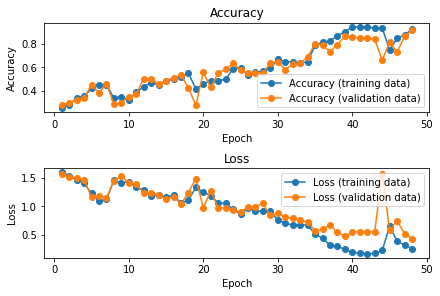

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, constrained_layout=True)
ax[0].plot(range(1, len(history.history['accuracy'])+1), history.history['accuracy'], label='Accuracy (training data)', marker='o')
ax[0].plot(range(1, len(history.history['accuracy'])+1), history.history['val_accuracy'], label='Accuracy (validation data)', marker='o')
ax[0].set_title('Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc="lower right")

ax[1].plot(range(1, len(history.history['accuracy'])+1), history.history['loss'], label='Loss (training data)', marker='o')
ax[1].plot(range(1, len(history.history['accuracy'])+1), history.history['val_loss'], label='Loss (validation data)', marker='o')
ax[1].set_title('Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc="upper right")

plt.show()

## **Load the best model**

In [16]:
model = tf.keras.models.load_model("/content/best_model.h5")

## **Testing the model**

In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

train_prediction = np.argmax(model.predict(padded_train), axis=1)
test_prediction = np.argmax(model.predict(padded_test), axis=1)

print("Accuracy data train : ", accuracy_score(train_prediction,
                                               np.argmax(y_train, axis=1)))
print("Accuracy data test : ", accuracy_score(test_prediction,
                                              np.argmax(y_test, axis=1)))

print()

print("Classification Report")
print(classification_report(test_prediction, np.argmax(y_test, axis=1), target_names=['Business', 'Entertaintment', 'Politics', 'Sport', 'Tech']))

print("Confussion Matrix")
print(confusion_matrix(test_prediction, np.argmax(y_test, axis=1)))

Accuracy data train :  0.9870786516853932
Accuracy data test :  0.9123595505617977

Classification Report
                precision    recall  f1-score   support

      Business       0.88      0.86      0.87       105
Entertaintment       0.86      0.84      0.85        79
      Politics       0.93      0.95      0.94        82
         Sport       0.98      0.98      0.98       102
          Tech       0.90      0.94      0.92        77

      accuracy                           0.91       445
     macro avg       0.91      0.91      0.91       445
  weighted avg       0.91      0.91      0.91       445

Confussion Matrix
[[ 90   5   2   0   8]
 [  8  66   3   2   0]
 [  1   3  78   0   0]
 [  0   2   0 100   0]
 [  3   1   1   0  72]]
